In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph, get_test_log_likelihood
from generative_model import inhomogeneous_poisson_process_g2

# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- lower bound >0 ???
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def gram_matrix(xs):
    return np.array([[ard_kernel(x1,x2) for x2 in xs] for x1 in xs])

def ard_kernel(x1,x2):
    R = 2
    a = np.ones([R])*5
    g = 0.7
    return g * np.prod([np.exp(-1 * ((x1-x2) ** 2) / (2 * a[r])) for r in range(R)])

def gaussian_process_rate_function(xs):
    mean = [0 for x in xs]
    gram = gram_matrix(xs)
    result = np.random.multivariate_normal(mean, gram)**2

    return result

In [3]:
upper_bound = 2
Tlims = np.array([[0., 10.], [0., 10.]])
res = 50
lam_star = 10.
params = np.array([2.,1.5])
                  
#generate samples
#samples,test_samples, _,xx, yy,vals = get_scp_samples(gaussian_process_rate_function, Tlims, upper_bound,res)
#plot_vals = vals.reshape(res,res)
                  
X_sets, intensity_sets, X_grid, intensity_array = inhomogeneous_poisson_process_g2(Tlims, lam_star, 'ard',
                                     params, grid_points=res, seed=None,
                                     num_sets=2)   
samples = X_sets[0]
test_samples = X_sets[1]
plot_vals = intensity_array
vals = intensity_array
xx,yy = np.meshgrid(X_grid[:,0],X_grid[:,1])

2014


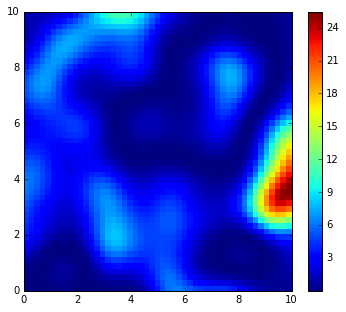

25.4432074375


In [4]:
#plot the rate_function over a grid
plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, plot_vals.reshape(res,res))
plt.colorbar()
plt.show()

print(np.max(plot_vals))

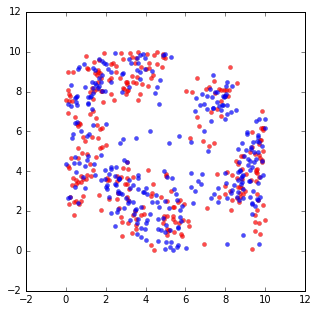

In [5]:
# sampled data:
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7, c='r')
plt.scatter(test_samples[:,0], test_samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

In [9]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)
check_numerics = True
init_debug     = True

# general options
train_hyperparameters    = False
optimize_inducing_points = False
ind_point_num            = 10

stabilizer_value     = 1e-5
kzz_stabilizer_value = 1e-7

# gradient descent options
max_iterations = 200
chk_iterations = 2001
learning_rate  = 0.0001

# initialization:
lvech_init_stddev = 0.1 
m_init_val        = 0.1

alphas_init = [1.5,  1.5]
gamma_init  = 2.

# tensorboard options:
logdir = 'logs/2d_example'

# build_evaluation_grid
eval_res = 100
eval_grid = build_2d_grid(Tlims, eval_res)
        
m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, ind_point_num, Tlims, 
                                                                          optimize_inducing_points=optimize_inducing_points, 
                                                                          train_hyperparameters=train_hyperparameters,
                                                                          learning_rate=learning_rate,
                                                                          max_iterations=max_iterations,
                                                                          chk_iters = chk_iterations,
                                                                          log_dir=logdir,
                                                                          alphas_init=alphas_init,
                                                                          gamma_init=gamma_init,
                                                                          lvech_init_stddev=lvech_init_stddev,
                                                                          m_init_val=m_init_val,
                                                                          check_numerics=check_numerics,
                                                                          stabilizer_value=stabilizer_value,
                                                                          kzz_stabilizer_value=kzz_stabilizer_value,
                                                                          enable_initialization_debugging=init_debug
                                                                         )
lam_vals, lam_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

Begin training
Fixed inducing points on a grid
Z.shape: (100, 2)
------------
INIT VALUES:
------------
Gamma 2.0
Alphas [ 1.5  1.5]
S:
[[ 0.02103585 -0.01130122 -0.01178219 ...,  0.01116524 -0.02119674
  -0.00274469]
 [-0.01130122  0.00917729  0.00450363 ..., -0.00534064  0.01029731
  -0.00268666]
 [-0.01178219  0.00450363  0.0078448  ..., -0.00606306  0.01255378
   0.00355821]
 ..., 
 [ 0.01116524 -0.00534064 -0.00606306 ...,  0.97532764 -0.08831151
  -0.01552276]
 [-0.02119674  0.01029731  0.01255378 ..., -0.08831151  0.9347816
  -0.04340745]
 [-0.00274469 -0.00268666  0.00355821 ..., -0.01552276 -0.04340745
   1.1712684 ]]
S_grad:
[[  4.31200373e+04   4.11031232e+03   3.38322770e+03 ...,   7.13485247e+00
    1.01086375e+00  -2.66143153e+00]
 [  4.11031232e+03   4.53144658e+04  -7.55197954e+02 ...,  -1.78047501e+00
   -1.05300832e+01  -1.84612193e+00]
 [  3.38322770e+03  -7.55197954e+02   4.75285476e+04 ...,  -4.36203540e+00
    5.15381785e+00   3.93336630e+00]
 ..., 
 [  7.13485247

In [10]:
#presentation

fig = plt.figure(figsize=(15, 5)) 
max_value = np.max([np.max(vals), np.max(lam_vals)])
norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

#print("ind point number: ",i)
print("alphas: ",alphas_opt)
print("gamma: ",gamma_opt)

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))

ax0 = plt.subplot(1,2,1)
im = ax0.pcolormesh(xx, yy, lam_vals.reshape(eval_res, eval_res),  norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('prediciton with samples')
ax0.scatter(samples[:,0], samples[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], res), np.linspace(Tlims[1,0], Tlims[1,1], res))

ax1 = plt.subplot(1,2, 2)
im1 = ax1.pcolormesh(xx, yy, plot_vals, norm=norm)
fig.colorbar(im1, ax=ax1)
ax1.set_title('groundtruth with inducing points')gamma_val
ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])
#plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
plt.show()

SyntaxError: invalid syntax (<ipython-input-10-6b7ad040f63e>, line 26)

In [ ]:
def get_lower_test_bound(test_samples, m, S, Kzz_inv, a, g, Z):
    lower_bound, Z_ph, X_test_ph, m_ph, S_ph,K_zz_inv_ph,a_ph,g_ph  = get_test_log_likelihood()

    #run session
    with tf.Session() as sess:
        lower_bound_val, = sess.run([lower_bound], feed_dict={Z_ph:Z, X_test_ph:test_samples,K_zz_inv_ph: Kzz_inv,S_ph:S,m_ph:m,a_ph:a,g_ph:g})

    return lower_bound_val
